# CNN 😎

In [1]:
import utilities as ff
import CNNModels

In [2]:
from tensorflow import config as tfconfig
from tensorflow.python.client import device_lib
try:
    print(tfconfig.list_physical_devices())
    print(device_lib.list_local_devices())
except:
    pass


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3483503308501624692
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1386046875
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13419923748499395706
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


https://www.tensorflow.org/tutorials/images/cnn

## HyperParameter

Parameters that could in particualr affect performance of a CNN model:

- Image size
- Colors
- Number of filters
- Number of layers
- Kernel size of filters

We propose 2 models to evaluate the latter 3, but first of all:

### Base Model

In [3]:
CNNModels.BASE().layers

### Thick model

- LESS LAYER
- MORE FILTERS
- ASCENDING KERNEL SIZE

In [4]:
CNNModels.THICK().layers

### Long Model

- MORE LAYERS
- LESS FILTERS
- DESCENDING KERNEL SIZE

In [5]:
CNNModels.LONG().layers

## Models

In [6]:
# ff.delete_from_list()

### Base

Found 24770 files belonging to 2 classes.
Using 7431 files for training.
Found 24770 files belonging to 2 classes.
Using 17339 files for validation.
Epoch 1/24
187/187 [==============================] - 16s 50ms/step - loss: 0.6744 - accuracy: 0.5536 - val_loss: 0.6069 - val_accuracy: 0.6664
Epoch 2/24
187/187 [==============================] - 11s 49ms/step - loss: 0.5887 - accuracy: 0.6830 - val_loss: 0.5451 - val_accuracy: 0.7208
Epoch 3/24
187/187 [==============================] - 11s 50ms/step - loss: 0.5273 - accuracy: 0.7367 - val_loss: 0.5048 - val_accuracy: 0.7609
Epoch 4/24
187/187 [==============================] - 11s 52ms/step - loss: 0.4711 - accuracy: 0.7704 - val_loss: 0.5280 - val_accuracy: 0.7446
Epoch 5/24
187/187 [==============================] - 11s 50ms/step - loss: 0.4302 - accuracy: 0.7980 - val_loss: 0.5478 - val_accuracy: 0.7507
Epoch 6/24
187/187 [==============================] - 11s 52ms/step - loss: 0.3634 - accuracy: 0.8322 - val_loss: 0.5466 - val_accu

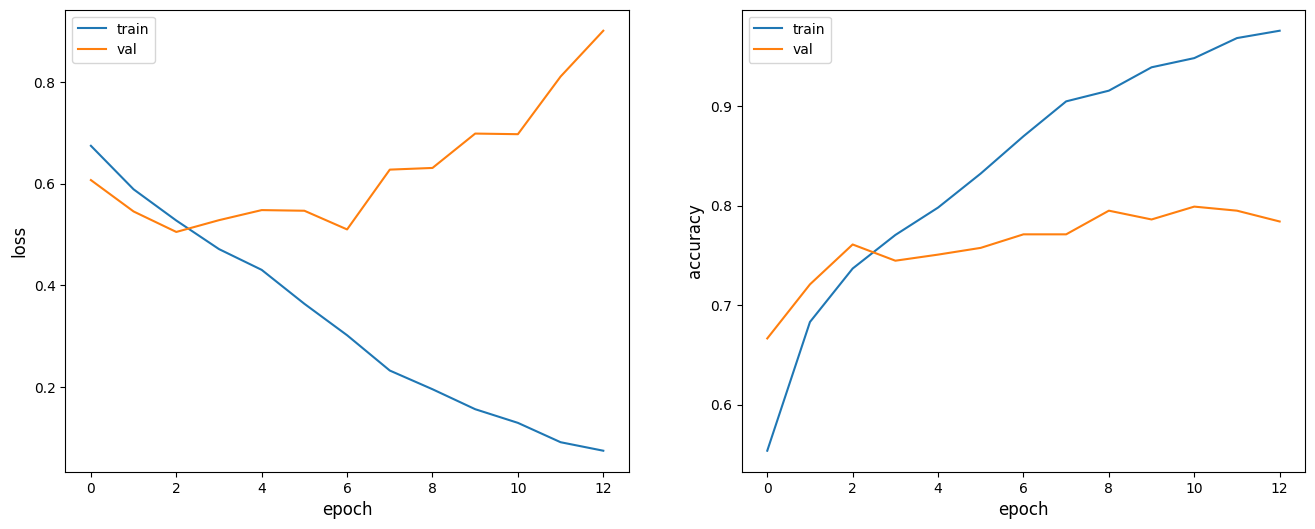

In [7]:
base_tag, base_test = ff.auto_train("BASE")

### Grayscale

Are color useless?

Found 24770 files belonging to 2 classes.
Using 7431 files for training.
Found 24770 files belonging to 2 classes.
Using 17339 files for validation.
Epoch 1/24
187/187 [==============================] - 10s 43ms/step - loss: 0.6929 - accuracy: 0.5316 - val_loss: 0.6771 - val_accuracy: 0.5482
Epoch 2/24
187/187 [==============================] - 9s 42ms/step - loss: 0.6516 - accuracy: 0.6092 - val_loss: 0.6495 - val_accuracy: 0.6359
Epoch 3/24
187/187 [==============================] - 9s 42ms/step - loss: 0.5923 - accuracy: 0.6864 - val_loss: 0.5760 - val_accuracy: 0.7031
Epoch 4/24
187/187 [==============================] - 9s 41ms/step - loss: 0.5234 - accuracy: 0.7401 - val_loss: 0.5592 - val_accuracy: 0.7065
Epoch 5/24
187/187 [==============================] - 9s 43ms/step - loss: 0.4607 - accuracy: 0.7785 - val_loss: 0.5646 - val_accuracy: 0.7351
Epoch 6/24
187/187 [==============================] - 9s 43ms/step - loss: 0.3878 - accuracy: 0.8261 - val_loss: 0.6157 - val_accuracy:

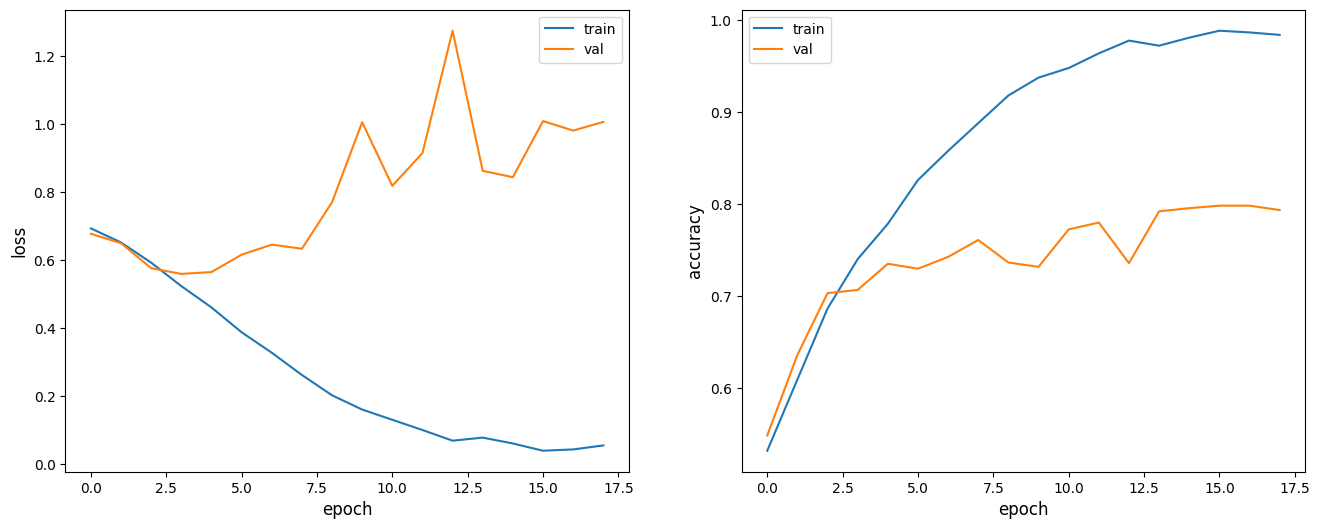

In [8]:
gray_tag, gray_test = ff.auto_train("BASE", color_mode="grayscale")

### Smaller images

Are high resolution images worth?

Found 24770 files belonging to 2 classes.
Using 7431 files for training.
Found 24770 files belonging to 2 classes.
Using 17339 files for validation.
Epoch 1/24
187/187 [==============================] - 11s 44ms/step - loss: 0.6935 - accuracy: 0.4930 - val_loss: 0.6933 - val_accuracy: 0.4878
Epoch 2/24
187/187 [==============================] - 8s 36ms/step - loss: 0.6932 - accuracy: 0.4932 - val_loss: 0.6933 - val_accuracy: 0.4891
Epoch 3/24
187/187 [==============================] - 9s 39ms/step - loss: 0.6932 - accuracy: 0.4929 - val_loss: 0.6934 - val_accuracy: 0.4871
Epoch 4/24
187/187 [==============================] - 10s 42ms/step - loss: 0.6933 - accuracy: 0.4893 - val_loss: 0.6934 - val_accuracy: 0.4864
Epoch 5/24
187/187 [==============================] - 9s 41ms/step - loss: 0.6933 - accuracy: 0.4912 - val_loss: 0.6934 - val_accuracy: 0.4898


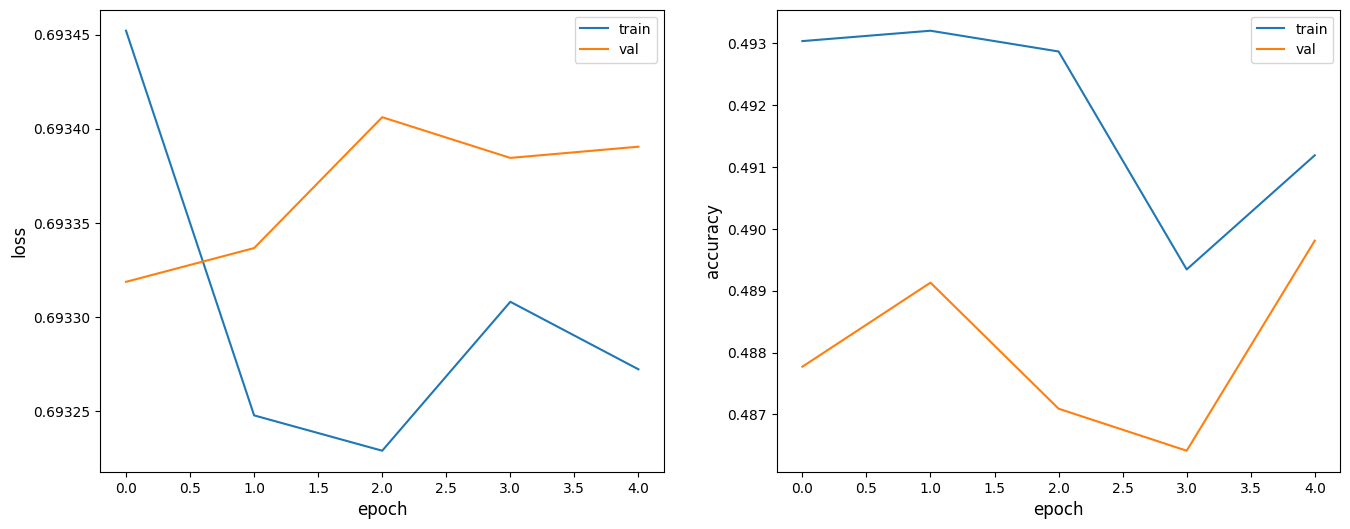

In [9]:
small_tag, small_test = ff.auto_train("BASE", image_size=64)

### Thick

Found 24770 files belonging to 2 classes.
Using 7431 files for training.
Found 24770 files belonging to 2 classes.
Using 17339 files for validation.
Epoch 1/24
187/187 [==============================] - 23s 109ms/step - loss: 0.6961 - accuracy: 0.5296 - val_loss: 0.6727 - val_accuracy: 0.6284
Epoch 2/24
187/187 [==============================] - 21s 105ms/step - loss: 0.6528 - accuracy: 0.6172 - val_loss: 0.6055 - val_accuracy: 0.6637
Epoch 3/24
187/187 [==============================] - 21s 107ms/step - loss: 0.6013 - accuracy: 0.6775 - val_loss: 0.5719 - val_accuracy: 0.7099
Epoch 4/24
187/187 [==============================] - 22s 111ms/step - loss: 0.5229 - accuracy: 0.7446 - val_loss: 0.5703 - val_accuracy: 0.7167
Epoch 5/24
187/187 [==============================] - 22s 113ms/step - loss: 0.4652 - accuracy: 0.7830 - val_loss: 0.5389 - val_accuracy: 0.7235
Epoch 6/24
187/187 [==============================] - 22s 112ms/step - loss: 0.3935 - accuracy: 0.8214 - val_loss: 0.4893 - va

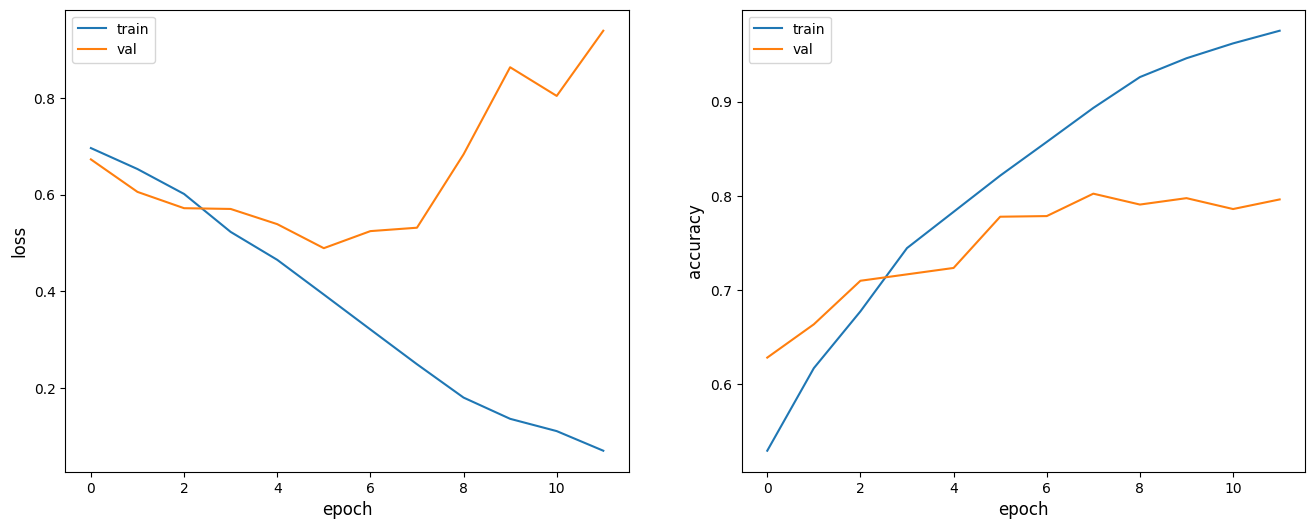

In [10]:
thick_tag, thick_test = ff.auto_train("THICK")

### Long

Found 24770 files belonging to 2 classes.
Using 7431 files for training.
Found 24770 files belonging to 2 classes.
Using 17339 files for validation.
Epoch 1/24
187/187 [==============================] - 15s 68ms/step - loss: 0.6935 - accuracy: 0.4950 - val_loss: 0.6934 - val_accuracy: 0.4878
Epoch 2/24
187/187 [==============================] - 14s 66ms/step - loss: 0.6933 - accuracy: 0.4942 - val_loss: 0.6934 - val_accuracy: 0.4891
Epoch 3/24
187/187 [==============================] - 14s 66ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6934 - val_accuracy: 0.4871
Epoch 4/24
187/187 [==============================] - 14s 66ms/step - loss: 0.6933 - accuracy: 0.4893 - val_loss: 0.6934 - val_accuracy: 0.4864
Epoch 5/24
187/187 [==============================] - 14s 67ms/step - loss: 0.6933 - accuracy: 0.4912 - val_loss: 0.6934 - val_accuracy: 0.4898


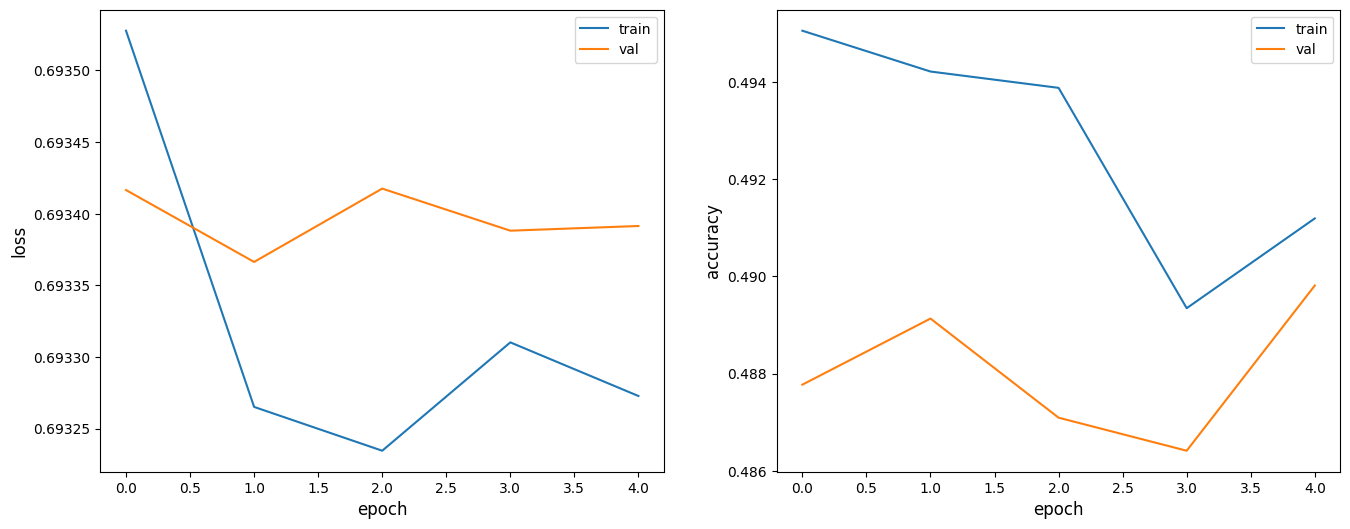

In [11]:
thick_tag, thick_test = ff.auto_train("LONG")

## Risk Estimation

Let's comprare best and worst model

In [12]:
# BEST
best_accuracies = ff.k_fold_cross_validation("BEST", small_test, "THICK")
best_avg_loss = 1 - sum(best_accuracies) / len(best_accuracies)

print("Risk estimation (average zero one loss): ", best_avg_loss)

FSIZE: 326 108 108
-----------------------------------
>> Train fold 1 ...
-----------------------------------
Epoch 1/24
326/326 - 44s - loss: 0.6487 - accuracy: 0.6055 - val_loss: 0.5275 - val_accuracy: 0.7480 - 44s/epoch - 134ms/step
Epoch 2/24
326/326 - 20s - loss: 0.5306 - accuracy: 0.7314 - val_loss: 0.5030 - val_accuracy: 0.7604 - 20s/epoch - 63ms/step
Epoch 3/24
326/326 - 21s - loss: 0.4562 - accuracy: 0.7819 - val_loss: 0.4452 - val_accuracy: 0.7876 - 21s/epoch - 65ms/step
Epoch 4/24
326/326 - 20s - loss: 0.4040 - accuracy: 0.8137 - val_loss: 0.4103 - val_accuracy: 0.8157 - 20s/epoch - 62ms/step
Epoch 5/24
326/326 - 20s - loss: 0.3492 - accuracy: 0.8457 - val_loss: 0.5316 - val_accuracy: 0.7821 - 20s/epoch - 61ms/step
Epoch 6/24
326/326 - 20s - loss: 0.3047 - accuracy: 0.8685 - val_loss: 0.4151 - val_accuracy: 0.8258 - 20s/epoch - 62ms/step
Epoch 7/24
326/326 - 19s - loss: 0.2568 - accuracy: 0.8918 - val_loss: 0.4326 - val_accuracy: 0.8270 - 19s/epoch - 58ms/step
Epoch 8/24
32

In [13]:
# WORST
worst_accuracies = ff.k_fold_cross_validation("WORST", gray_test, "LONG")
worst_avg_loss = 1 - sum(worst_accuracies) / len(worst_accuracies)

print("Risk estimation (average zero one loss): ", worst_avg_loss)

FSIZE: 326 108 108
-----------------------------------
>> Train fold 1 ...
-----------------------------------
Epoch 1/24
326/326 - 22s - loss: 0.6940 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5038 - 22s/epoch - 67ms/step
Epoch 2/24
326/326 - 21s - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5032 - 21s/epoch - 63ms/step
Epoch 3/24
326/326 - 21s - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.5014 - 21s/epoch - 64ms/step
Epoch 4/24
326/326 - 21s - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.5041 - 21s/epoch - 65ms/step
Epoch 5/24
326/326 - 21s - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5020 - 21s/epoch - 66ms/step
-----------------------------------
<< Eval fold 1 ...
-----------------------------------
108/108 [==============================] - 3s 22ms/step - loss: 0.6932 - accuracy: 0.4928
Score for fold 1:
>> loss of 0.6932336091995239
>> accuracy of 0.49276620149612427
